In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown

# Load the dataset

In [3]:
# download data if needed from https://drive.google.com/drive/folders/1vdO8CJluRp7sOOQHc85YYZXhV2p2QcDN
gdown.download(
    'https://drive.google.com/uc?id=1QK5Ua4HStjIm3URxw4WHHM2gdzDmbvsN',
    '../data/10xpbmc10k-2020/expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1QK5Ua4HStjIm3URxw4WHHM2gdzDmbvsN
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/data/10xpbmc10k-2020/expressions.h5ad
48.8MB [00:00, 93.3MB/s]


'../data/10xpbmc10k-2020/expressions.h5ad'

In [3]:
 gdown.download(
    'https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc',
    '../data/10xpbmc10k-2020/peaks.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/data/10xpbmc10k-2020/peaks.h5ad
789MB [00:05, 153MB/s]  


'../data/10xpbmc10k-2020/peaks.h5ad'

In [4]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

# Define reference and query

In [6]:
# reference
scrna_ref = scrna[:7000]
scatac_ref = scatac[:7000]

In [7]:
# query
scrna_query = scrna[7000:]
scatac_query = scatac[7000:]

# Configure and train the model

To configure the model, we need to specify the following parameters:
- pair_groups = whether the dtaa is paired or not; if the data is paired same number should be passed, e.g. [[0], [0]] or [[1], [1]], if not paired then different numbers, e.g. [[0], [1]]
- condition = whether the model is a cVAE. Set to True if using query to reference mapping
- z_dim = number of dimentions in the latent space
- h_dim = number of dimentions in the hidden space, i.e. output dimention of the modality encoders and input dimention of the shared encoder
- hiddens = dimentionality of hidden layers in modality encoders/decoders; e.g. if hiddens = [[512], [1024]] then the input dimentions of modality encoders would be 3999 -> 512 -> 128 for rna and 40018 -> 1024 -> 128 for atac
- losses = loss per modality. Has to be one of ['mse', 'nb', 'zinb', 'bce']. We recomend using 'nb' with raw gene counts or 'mse' with normalized gene expressions, 'mse' with normalized protein data and 'bce' with binarized peaks or 'mse' with mormalized peaks
- layers = which layer in AnnData onject to use. Default is to use .X but if layer is specified per modality, use that one.
- output_actiations = activation funtions of the last layer of modelity decoders; has to be one of ['linear', 'relu', 'leakyrelu', 'sigmoid', 'softmax']. Note that for NB or ZINB losses the activation function is always a softmax and for BCE loss it's always sigmoid, so it doesn't matter which one you specify for those positions.
- shared_hiddens = dimentionality of hidden layers in the shared encoder/decoder; e.g. if shared_hiddens = [64], then the input dimentions of the shared encoder would be 128 -> 64 -> 20
- recon_coef = reconstruction coefficient, i.e. the weight of MSE reconstruction loss in the total loss (the higher the more important)
- kl_coef = KL-divergence loss coefficient
- cycle_coef = cycle consistency loss coefficient

Additionally, adatas, names, pair_groups and hiddens should have the same number of modalities and the same length per modality.

In [8]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[['pair1'], ['pair1']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=5e-5,
    integ_coef=1e-2, # don't have it here as just one pair
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [9]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=200
)

 |████████████████████| 100.0% iter=10000/10000, time=14.27(s), loss=1.4030, recon=1.4024, kl=52.7443, integ=0.0000, cycle=0.0000, val_loss=1.3347, val_recon=1.3342, val_kl=47.8523, val_integ=0.0000, val_cycle=0.0000

## Plot training history
Note that there's only one pair of datasets so we don't have the integration loss here.

In [10]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,200,1.599253,1.599247,10.955746,0.0,0.0,1.508915,1.508909,9.756491,0,0
1,400,1.604574,1.604555,16.375862,0.0,0.0,1.373158,1.373141,14.876903,0,0
2,600,1.540311,1.540279,18.596922,0.0,0.0,1.361533,1.361502,17.861916,0,0
3,800,1.378064,1.378012,22.643187,0.0,0.0,1.356326,1.356278,20.728127,0,0
4,1000,1.345656,1.345581,26.398750,0.0,0.0,1.352335,1.352270,22.680523,0,0
5,1200,1.301330,1.301234,28.236349,0.0,0.0,1.350608,1.350518,26.251720,0,0
6,1400,1.243767,1.243646,30.328682,0.0,0.0,1.348625,1.348508,29.398752,0,0
7,1600,1.502492,1.502341,33.174957,0.0,0.0,1.348011,1.347868,31.222385,0,0
8,1800,1.411548,1.411376,33.376732,0.0,0.0,1.346105,1.345936,32.938816,0,0
9,2000,1.342470,1.342239,40.338051,0.0,0.0,1.345230,1.345026,35.694286,0,0


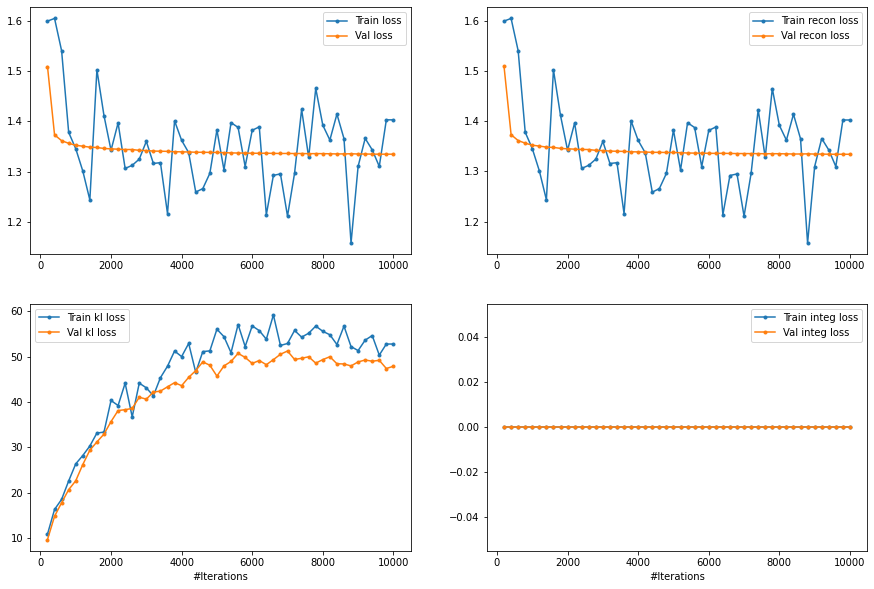

In [11]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

### UMAP plot of the latent space

In [12]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]], # can be different from above, just need to be the same
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [13]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


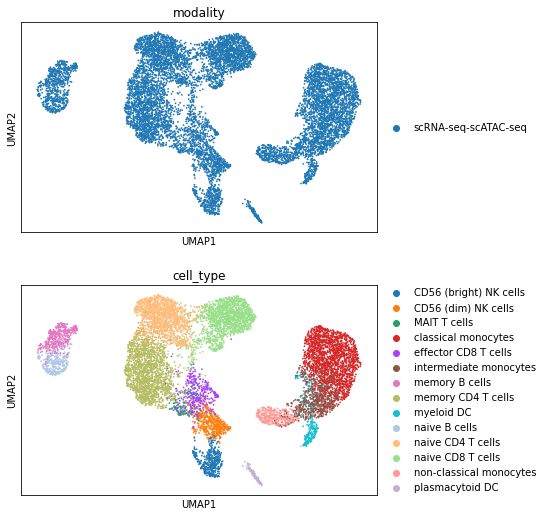

In [14]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

# Map new query data onto the reference

We operate on the old model to add new batch labels. When you first train a model on lets say [[rna1, rna2], [atac1]] adatas, then internally batch labels are [[0, 1], [0]], i.e. the numeration starts with 0 and is independent of the modality and if the data is paired or not.

When we add new datasets, say [[rna3], [atac2]] the new batch labels for this data are [[2], [1]]. We need to keep track of it for later inference.

In this example, batch labels corresponding to [[scrna_ref, scrna_query], [scatac_ref, scatac_query]] are [[0, 1], [0, 1]].

In operate, we again need adatas, names and pair_groups have the same number of modalities and the same length per modality. Also even if we are adding to only one modality, e.g. adatas=[[scrna_query], []], you need to specify that the list with the new query data for the second modality is empty.

fine_tune parameter indicates if we want to fine-tune the first layer of the changed modality encoders/decoders or only newly added conditional weights, has to be either 'cond_weights' or 'first_layer'.

In [15]:
new_model = mtg.operate(model, 
                   adatas=[[scrna_query],[scatac_query]],
                    names=[['scRNA-seq-query'], ['scATAC-seq-query']],
                    pair_groups=[[0],[0]],
                    fine_tune='cond_weights')

In [16]:
new_model.train(
    n_iters=1000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=500
)

 |████████████████████| 100.0% iter=1000/1000, time=37.23(s), loss=0.8783, recon=0.8779, kl=51.3293, integ=0.0000, cycle=0.0000, val_loss=0.8674, val_recon=0.8669, val_kl=49.5084, val_integ=0.0000, val_cycle=0.0000

## Get the latent representation for the query data only

In [17]:
z = new_model.predict(
    adatas=[[scrna_query], [scatac_query]],
    names=[['scRNA-seq-query'], ['scATAC-seq-query']],
    pair_groups=[[0], [0]],
    batch_labels=[[1], [1]], #same as the model was trained on
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 3000 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [18]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


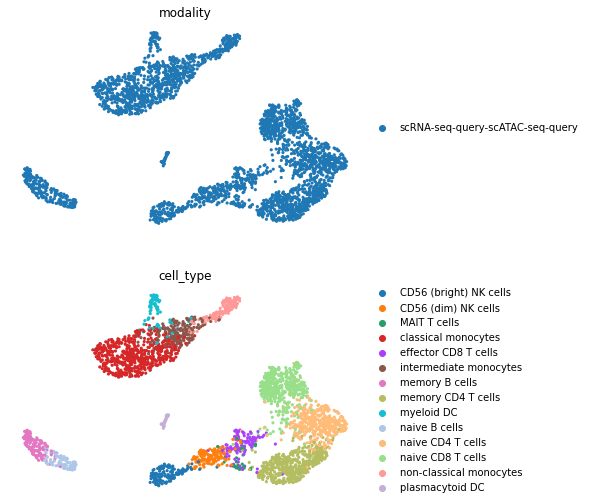

In [19]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1, frameon=False)

## Get the latent representation for both the reference and the query

In [20]:
z = new_model.predict(
    adatas=[[scrna_ref, scrna_query], [scatac_ref, scatac_query]],
    names=[['scRNA-seq-ref', 'scRNA-seq-query'], ['scATAC-seq-ref', 'scATAC-seq-query']],
    batch_labels=[[0, 1], [0, 1]], #same as the model was trained on
    pair_groups=[[0, 1], [0, 1]],
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [21]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


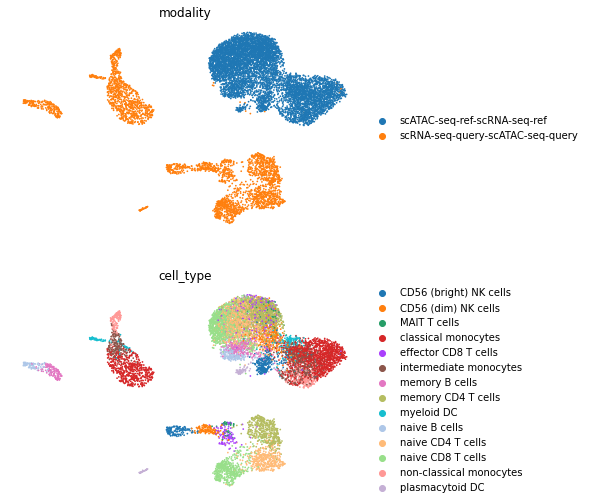

In [22]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1, frameon=False)

# Metrics
See scIB metrics (https://github.com/theislab/scib).

In [23]:
metrics = mtg.metrics.metrics(None, z, batch_key='modality', label_key='cell_type',
                             pcr_batch=False, isolated_label_f1=False)
metrics

Clustering...
ASW label/batch...
Graph connectivity...
ASW label...
NMI cluster/label...
ARI cluster/label...
Isolated label silhouette...


,score
ASW_label/batch,0.321260
graph_conn,0.470683
ASW_label,0.493428
NMI_cluster/label,0.552169
ARI_cluster/label,0.351667
isolated_label_silhouette,0.533259


In [24]:
new_model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,999,0.878298,0.87792,51.329324,0.0,0.0,0.8674,0.866905,49.50838,0,0
